# **IMPORTADO DE MÓDULOS/PULSOS**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import initializers
from keras.regularizers import l2
from keras.optimizers import Adam

2024-05-06 21:55:22.866920: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 21:55:22.892268: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 21:55:23.295600: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from scipy.optimize import curve_fit
#https://gist.github.com/cpascual/a03d0d49ddd2c87d7e84b9f4ad2df466
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [3]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

# **PREPROCESSING AND FUNCTIONS**

In [4]:
start = 50
stop = 80
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28[:,start:stop,:]
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28[:,start:stop,:],  kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55[:,start:stop,:],  kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82[:,start:stop,:],  kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 30
Time step: 0.20
New number of time points: 240
New time step: 0.0250


In [5]:
def momentos(vector):
  Nev,Nt,Nc = np.shape(vector)    #Nev: Núm eventos, Nt: Núm puntos temporales, Nc: Número canales
  t = np.reshape(np.linspace(0,Nt, Nt)/float(Nt),(1,-1,1))#Normalized array of time
  MOMENT = np.zeros((Nev,0,Nc))

  for i in range(4): #Number of moments used
    W = t**(i+1)
    W = np.tile(W,(Nev,1,Nc))
    MM = np.sum(vector*W,axis=1,keepdims=True)
    MOMENT = np.append(MOMENT,MM,axis=1)

    W = np.exp(-(i)*t)
    W = np.tile(W,(Nev,1,Nc))
    MM = np.sum(vector*W,axis=1,keepdims=True)
    MOMENT = np.append(MOMENT,MM,axis=1)

    W = np.exp(-(t**i))
    W = np.tile(W,(Nev,1,Nc))
    MM = np.sum(vector*W,axis=1,keepdims=True)
    MOMENT = np.append(MOMENT,MM,axis=1)


  return MOMENT

In [6]:
INPUT = np.concatenate((new_V55,new_V28,new_V82),axis=0)
Ncasos = INPUT.shape[0]
Ncasos = 1000
Nc = 2
t_shift = 8 #In time steps
t = np.linspace(0,Nt,Nt_new)
t0 = 65 - start + np.random.randint(8, size=Ncasos)

# **GET CLOSEST PULSE TO EACH**

In [7]:
from scipy import signal

def get_correlation(ref_pulse, pulse_set, channel = 0):
  """Function to calculate the correlation of a
  reference pulse to every pulse in a set"""
  y1 = ref_pulse
  n = len(y1)
  correlation = []
  for i in range(pulse_set.shape[0]):
    y2 = pulse_set[i,:,channel]
    corr = signal.correlate(y2, y1, mode = 'same')
    correlation.append(corr[n//2]) #Correlation at delay zero
  correlation = np.array(correlation)
  return correlation

In [8]:
def get_closest(ref_pulse, pulse_set, channel = 0):
  """Function to calculate the most similar
  pulse in a set to a reference one"""
  y1 = ref_pulse
  mse = []
  for i in range(pulse_set.shape[0]):
    y2 = pulse_set[i,:,channel]
    mse.append(np.mean((y1-y2)**2))
  mse = np.array(mse)
  sorted_indices = np.argsort(mse)
  index_of_closest = sorted_indices[1]
  return index_of_closest

In [9]:
def create_set(og_set, channel = 0):
  new_set = np.zeros_like(og_set)
  for i in range(og_set.shape[0]):
    closest = get_closest(og_set[i,:,channel], og_set, channel = channel)
    new_set[i,:,0] = og_set[i,:,channel]
    new_set[i,:,1] = og_set[closest,:,channel]
  return new_set

In [10]:
set_V28_dec0 = create_set(new_V28, channel = 0)
set_V55_dec0 = create_set(new_V55, channel = 0)
set_V82_dec0 = create_set(new_V82, channel = 0)
full_set_dec0 = np.concatenate((set_V28_dec0, set_V55_dec0, set_V82_dec0), axis = 0)

set_V28_dec1 = create_set(new_V28, channel = 1)
set_V55_dec1 = create_set(new_V55, channel = 1)
set_V82_dec1 = create_set(new_V82, channel = 1)
full_set_dec1 = np.concatenate((set_V28_dec1, set_V55_dec1, set_V82_dec1), axis = 0)

# **MEAN PULSE CALC. USING FOURIER TRANSFORM**

In [11]:
signals_dec0 = V55[:,:,0]
signals_dec1 = V55[:,:,1]

In [12]:
transforms = []
magnitude = []
phase = []

for i in range(signals_dec0.shape[0]):
  fourier_transform = np.fft.fft(V55[i,:,0])
  transforms.append(fourier_transform)
  magnitude.append(np.abs(fourier_transform))
  phase.append(np.angle(fourier_transform))

transforms = np.array(transforms, dtype='object')
magnitude = np.array(magnitude, dtype='object')
phase = np.array(phase, dtype='object')

Text(0, 0.5, 'Magnitude (Arb. units)')

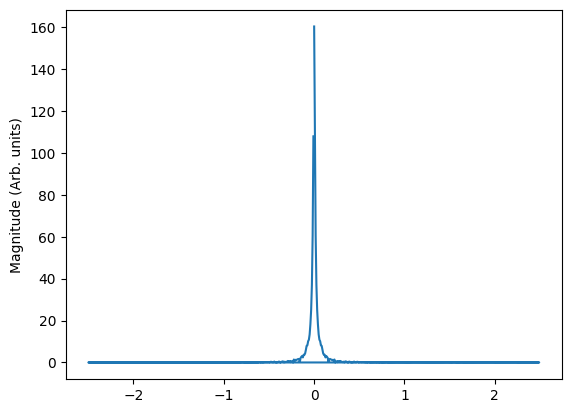

In [13]:
time_step = 0.2 #ns
freqs = np.fft.fftfreq(V55.shape[1], time_step)  # Compute frequency axis
plt.plot(freqs,magnitude[0,:])
plt.ylabel('Magnitude (Arb. units)')

/home/josea/.local/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/josea/.local/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Pulses minus mean')

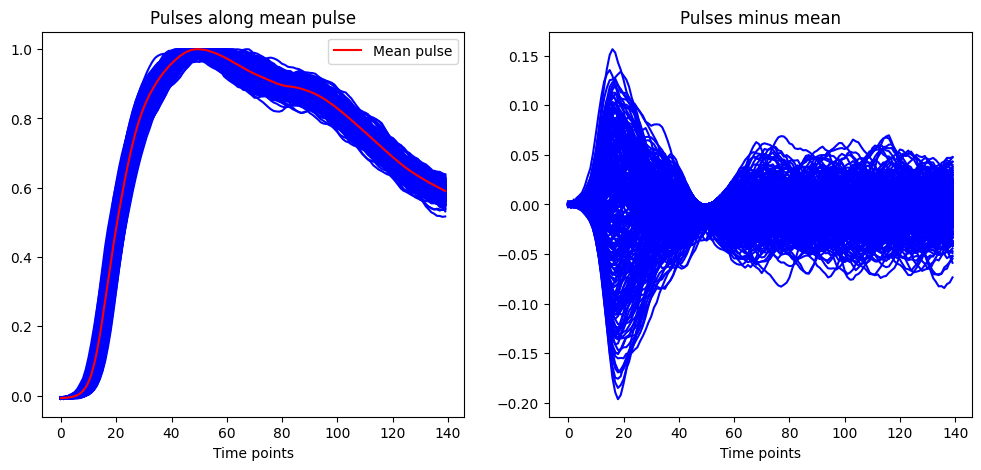

In [14]:
sum_of_transf = np.sum(transforms, axis = 0)
reconstructed_signal = np.fft.ifft(sum_of_transf)
normalized_recons = reconstructed_signal/np.max(reconstructed_signal)




start = 60
stop = 200
plt.figure(figsize=(12,5))
plt.subplot(121)
for i in range(V55.shape[0]):
  plt.plot(V55[i,:,0][start:stop],'b-')
plt.plot(normalized_recons[start:stop],'r-', label = 'Mean pulse')
plt.xlabel('Time points')
plt.legend()
plt.title('Pulses along mean pulse')

plt.subplot(122)
for i in range(V55.shape[0]):
  plt.plot(V55[i,:,0][start:stop]-normalized_recons[start:stop],'b-')
plt.xlabel('Time points')
plt.title('Pulses minus mean')


# **DETECTOR 0**

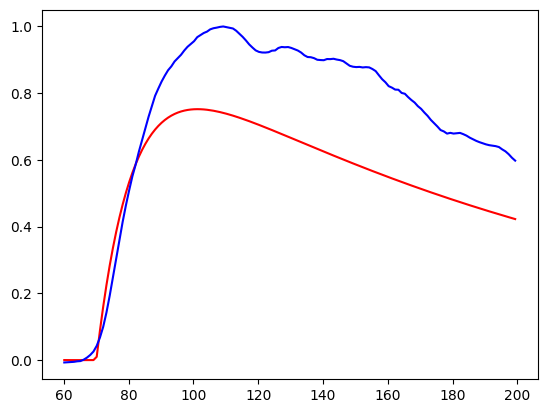

In [15]:
def pulso(t,t0):
  noise = np.random.normal(scale=0.01, size=len(t)-t0)
  noise2 = np.random.normal(scale=1e-4, size=t0)
  smoothed_noise = gaussian_filter1d(noise, sigma=30)
  y=(1-np.exp(-(t-t0)/12))*np.exp(-(t-t0)/150)
  y[y<0.] = 0
  y[t0:] = y[t0:] + smoothed_noise
  y[:t0] = y[:t0] + noise2
  #y = y / np.max(y)
  return y

tt=np.linspace(0,600,600)   #time step of 0.2ns
pulso_original = pulso(tt,70)


plt.plot(tt[start:stop],pulso_original[start:stop],'r-')
plt.plot(tt[start:stop],V28[0,start:stop,0],'b-')

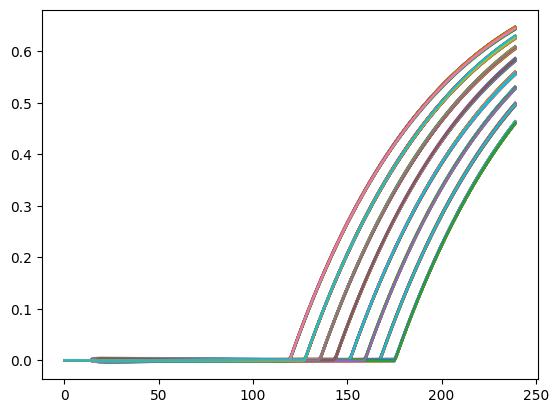

In [16]:
Ncasos = 1000
INPUT_dec0 = np.zeros((Ncasos,Nt_new,Nc))

for i in range(Ncasos):
  centro = t0[i]
  PULSO = pulso(t,centro)
  plt.plot(PULSO)
  INPUT_dec0[i,:,0] = PULSO
  INPUT_dec0[i,:,1] = PULSO

In [17]:
full_set_PULSO_dec0 = create_set(INPUT_dec0, channel = 0)

In [18]:
INPUT2_dec0 = np.zeros((full_set_dec0.shape[0],full_set_dec0.shape[1], 4))
REF_dec0_closest_delayed = np.zeros((full_set_dec0.shape[0],),dtype=np.float32)
REF_dec0_og_delayed = np.zeros((full_set_dec0.shape[0],),dtype=np.float32)

NRD0 = np.random.randint(20, size=full_set_dec0.shape[0])
NRD1 = np.random.randint(20, size=full_set_dec0.shape[0])
NRD2 = np.random.randint(20, size=full_set_dec0.shape[0])

for i in range(full_set_dec0.shape[0]):
  N0 = NRD0[i]
  noise00 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma=10)
  INPUT2_dec0[i,:,0]=np.roll(full_set_dec0[i,:,0],N0)
  INPUT2_dec0[i,:,0] = INPUT2_dec0[i,:,0]
  INPUT2_dec0[i,0:N0,0] = smoothed_noise[0:N0]

  INPUT2_dec0[i,:,2]=np.roll(full_set_dec0[i,:,1],N0)
  INPUT2_dec0[i,:,2] = INPUT2_dec0[i,:,2]
  INPUT2_dec0[i,0:N0,2] = smoothed_noise[0:N0]

  N1 = NRD1[i]
  noise11 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT2_dec0[i,:,1]=np.roll(full_set_dec0[i,:,0],N1)
  INPUT2_dec0[i,:,1] = INPUT2_dec0[i,:,1] + smoothed_noise
  INPUT2_dec0[i,0:N1,1] = smoothed_noise[0:N1]

  N2 = NRD2[i]
  noise22 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise22, sigma=10)
  INPUT2_dec0[i,:,3]=np.roll(full_set_dec0[i,:,1],N2)
  INPUT2_dec0[i,:,3] = INPUT2_dec0[i,:,3] + smoothed_noise
  INPUT2_dec0[i,0:N2,3] = smoothed_noise[0:N2]

  REF_dec0_og_delayed[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)
  REF_dec0_closest_delayed[i]=new_time_step*(N0-N2)  #in ns (t_shift is defined above)

#-----------------------------------------------------------------------------------------------------------
INPUT3_dec0 = np.zeros((full_set_PULSO_dec0.shape[0],full_set_PULSO_dec0.shape[1], 4))
REF_sim_dec0_closest_delayed = np.zeros((Ncasos,),dtype=np.float32)
REF_sim_dec0_og_delayed = np.zeros((Ncasos,),dtype=np.float32)


NRD0 = np.random.randint(20, size=Ncasos)
NRD1 = np.random.randint(20, size=Ncasos)
NRD2 = np.random.randint(20, size=Ncasos)

for i in range(Ncasos):
  N0 = NRD0[i]
  noise00 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma=10)
  INPUT3_dec0[i,:,0]=np.roll(full_set_PULSO_dec0[i,:,0],N0)
  INPUT3_dec0[i,:,0] = INPUT3_dec0[i,:,0]
  INPUT3_dec0[i,0:N0,0] = smoothed_noise[0:N0]

  INPUT3_dec0[i,:,2]=np.roll(full_set_PULSO_dec0[i,:,1],N0)
  INPUT3_dec0[i,:,2] = INPUT3_dec0[i,:,2]
  INPUT3_dec0[i,0:N0,2] = smoothed_noise[0:N0]

  N1 = NRD1[i]
  noise11 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT3_dec0[i,:,1]=np.roll(full_set_PULSO_dec0[i,:,0],N1)
  INPUT3_dec0[i,:,1] = INPUT3_dec0[i,:,1] + smoothed_noise
  INPUT3_dec0[i,0:N1,1] = smoothed_noise[0:N1]

  N2 = NRD2[i]
  noise22 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise22, sigma=10)
  INPUT3_dec0[i,:,3]=np.roll(full_set_PULSO_dec0[i,:,1],N2)
  INPUT3_dec0[i,:,3] = INPUT3_dec0[i,:,3] + smoothed_noise
  INPUT3_dec0[i,0:N2,3] = smoothed_noise[0:N2]

  REF_sim_dec0_og_delayed[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)
  REF_sim_dec0_closest_delayed[i]=new_time_step*(N0-N2)  #in ns (t_shift is defined above))

trainX_dec0 = np.concatenate((INPUT2_dec0, INPUT3_dec0), axis = 0)

REF_real_train_dec0 = np.vstack((REF_dec0_og_delayed, REF_dec0_closest_delayed)).T #shape = [batch_size, 2]
REF_sim_train_dec0 = np.vstack((REF_sim_dec0_og_delayed, REF_sim_dec0_closest_delayed)).T #shape = [batch_size, 2]
REF_train_dec0 = np.concatenate((REF_real_train_dec0, REF_sim_train_dec0), axis = 0)

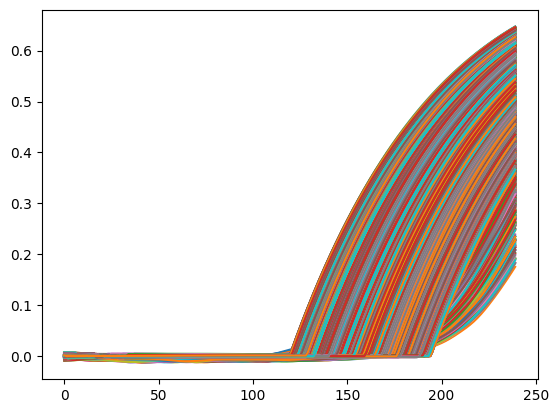

In [19]:
for i in range(trainX_dec0.shape[0]):
  plt.plot(trainX_dec0[i,:,0])
  plt.plot(trainX_dec0[i,:,2])

In [20]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)

min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

M_Train_dec0 = (M_Train_dec0-min_dec0)/(max_dec0 - min_dec0)

NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)

(1736, 12, 4) NM = 12


# **DETECTOR 1**

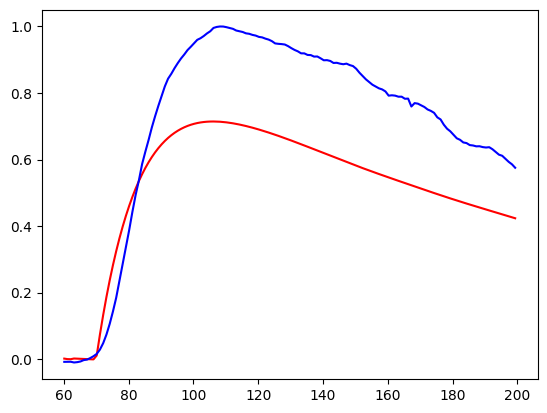

In [21]:
def pulso_dec1(t,t0):
  noise = np.random.normal(scale=0.01, size=len(t)-t0)
  noise2 = np.random.normal(scale=0.001, size=t0)
  smoothed_noise = gaussian_filter1d(noise, sigma=10)
  y=(1-np.exp(-(t-t0)/15))*np.exp(-(t-t0)/150) #15
  y[y<0.] = 0
  y[t0:] = y[t0:] + smoothed_noise
  y[:t0] = y[:t0] + noise2
  #y = y / np.max(y)
  return y


tt=np.linspace(0,600,600)   #time step of 0.2ns
pulso_original = pulso_dec1(tt,70)

plt.plot(tt[start:stop],pulso_original[start:stop],'r-')
plt.plot(tt[start:stop],V28[0,start:stop,1],'b-')

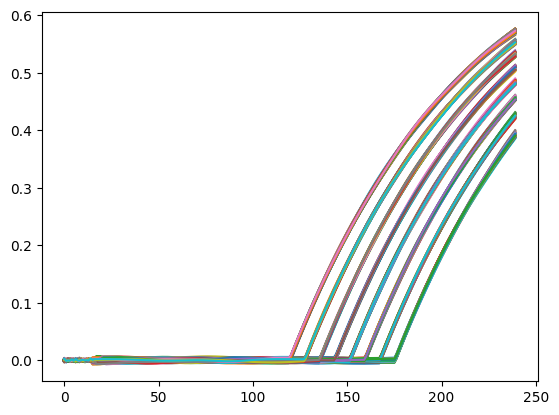

In [22]:
Ncasos = 1000
INPUT_dec1 = np.zeros((Ncasos,Nt_new,Nc))

for i in range(Ncasos):
  centro = t0[i]
  PULSO = pulso_dec1(t,centro)
  plt.plot(PULSO)
  INPUT_dec1[i,:,0] = PULSO
  INPUT_dec1[i,:,1] = PULSO
  
full_set_PULSO_dec1 = create_set(INPUT_dec1, channel = 0)

In [23]:
INPUT2_dec1 = np.zeros((full_set_dec1.shape[0],full_set_dec1.shape[1], 4))
REF_dec1_closest_delayed = np.zeros((full_set_dec1.shape[0],),dtype=np.float32)
REF_dec1_og_delayed = np.zeros((full_set_dec1.shape[0],),dtype=np.float32)

NRD0 = np.random.randint(20, size=full_set_dec1.shape[0])
NRD1 = np.random.randint(20, size=full_set_dec1.shape[0])
NRD2 = np.random.randint(20, size=full_set_dec1.shape[0])

for i in range(full_set_dec1.shape[0]):
  N0 = NRD0[i]
  noise00 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma=10)
  INPUT2_dec1[i,:,0]=np.roll(full_set_dec1[i,:,0],N0)
  INPUT2_dec1[i,:,0] = INPUT2_dec1[i,:,0]
  INPUT2_dec1[i,0:N0,0] = smoothed_noise[0:N0]

  INPUT2_dec1[i,:,2]=np.roll(full_set_dec0[i,:,1],N0)
  INPUT2_dec1[i,:,2] = INPUT2_dec1[i,:,2]
  INPUT2_dec1[i,0:N0,2] = smoothed_noise[0:N0]

  N1 = NRD1[i]
  noise11 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT2_dec1[i,:,1]=np.roll(full_set_dec1[i,:,0],N1)
  INPUT2_dec1[i,:,1] = INPUT2_dec1[i,:,1] + smoothed_noise
  INPUT2_dec1[i,0:N1,1] = smoothed_noise[0:N1]

  N2 = NRD2[i]
  noise22 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise22, sigma=10)
  INPUT2_dec1[i,:,3]=np.roll(full_set_dec1[i,:,1],N2)
  INPUT2_dec1[i,:,3] = INPUT2_dec1[i,:,3] + smoothed_noise
  INPUT2_dec1[i,0:N2,3] = smoothed_noise[0:N2]

  REF_dec1_og_delayed[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)
  REF_dec1_closest_delayed[i]=new_time_step*(N0-N2)  #in ns (t_shift is defined above)

#-----------------------------------------------------------------------------------------------------------
INPUT3_dec1 = np.zeros((full_set_PULSO_dec1.shape[0],full_set_PULSO_dec1.shape[1], 4))
REF_sim_dec1_closest_delayed = np.zeros((Ncasos,),dtype=np.float32)
REF_sim_dec1_og_delayed = np.zeros((Ncasos,),dtype=np.float32)


NRD0 = np.random.randint(20, size=Ncasos)
NRD1 = np.random.randint(20, size=Ncasos)
NRD2 = np.random.randint(20, size=Ncasos)

for i in range(Ncasos):
  N0 = NRD0[i]
  noise00 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma=10)
  INPUT3_dec1[i,:,0]=np.roll(full_set_PULSO_dec1[i,:,0],N0)
  INPUT3_dec1[i,:,0] = INPUT3_dec1[i,:,0]
  INPUT3_dec1[i,0:N0,0] = smoothed_noise[0:N0]

  INPUT3_dec1[i,:,2]=np.roll(full_set_PULSO_dec1[i,:,1],N0)
  INPUT3_dec1[i,:,2] = INPUT3_dec1[i,:,2]
  INPUT3_dec1[i,0:N0,2] = smoothed_noise[0:N0]

  N1 = NRD1[i]
  noise11 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT3_dec1[i,:,1]=np.roll(full_set_PULSO_dec1[i,:,0],N1)
  INPUT3_dec1[i,:,1] = INPUT3_dec1[i,:,1] + smoothed_noise
  INPUT3_dec1[i,0:N1,1] = smoothed_noise[0:N1]

  N2 = NRD2[i]
  noise22 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise22, sigma=10)
  INPUT3_dec1[i,:,3]=np.roll(full_set_PULSO_dec1[i,:,1],N2)
  INPUT3_dec1[i,:,3] = INPUT3_dec1[i,:,3] + smoothed_noise
  INPUT3_dec1[i,0:N2,3] = smoothed_noise[0:N2]

  REF_sim_dec1_og_delayed[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)
  REF_sim_dec1_closest_delayed[i]=new_time_step*(N0-N2)  #in ns (t_shift is defined above))

trainX_dec1 = np.concatenate((INPUT2_dec1, INPUT3_dec1), axis = 0)

REF_real_train_dec1 = np.vstack((REF_dec1_og_delayed, REF_dec1_closest_delayed)).T #shape = [batch_size, 2]
REF_sim_train_dec1 = np.vstack((REF_sim_dec1_og_delayed, REF_sim_dec1_closest_delayed)).T #shape = [batch_size, 2]
REF_train_dec1 = np.concatenate((REF_real_train_dec1, REF_sim_train_dec1), axis = 0)

In [24]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec1 = momentos(trainX_dec1)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec1 = (M_Train_dec1-min_dec1)/(max_dec1 - min_dec1)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)

(1736, 12, 4) NM = 12


# **FULL TOF**

In [25]:
REFERENCE_PULSE_dec0 = np.tile(new_V55[0,:,0], (new_V82.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(new_V55[0,:,1], (new_V82.shape[0],2,1)).swapaxes(1,2)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0)
M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0-min_dec0)

M_REF_dec1 = momentos(REFERENCE_PULSE_dec1)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1-min_dec1)


M_V28 = momentos(new_V28)
M_V28_norm = np.zeros_like(M_V28)
M_V28_norm[:,:,0] = (M_V28[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V28_norm[:,:,1] = (M_V28[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V28.shape)

M_V55 = momentos(new_V55)
M_V55_norm = np.zeros_like(M_V55)
M_V55_norm[:,:,0] = (M_V55[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V55_norm[:,:,1] = (M_V55[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V55.shape)

M_V82 = momentos(new_V82)
M_V82_norm = np.zeros_like(M_V82)
M_V82_norm[:,:,0] = (M_V82[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V82_norm[:,:,1] = (M_V82[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V82.shape)

(187, 12, 2)
(268, 12, 2)
(281, 12, 2)


In [26]:
from tensorflow.keras.layers import Dense, Input, concatenate

def model_definition(NM):

  inputA = Input(shape=(NM,))
  inputB = Input(shape=(NM,))
  inputC = Input(shape=(NM,))
  inputD = Input(shape=(NM,))

  x1 = Dense(64, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1) , kernel_regularizer=l2(0.01))
  x2 = Dense(64, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1) , kernel_regularizer=l2(0.01))
  x3 = Dense(64, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1) , kernel_regularizer=l2(0.01))
  x4 = Dense(1, activation="relu")

  op1A = x1(inputA)
  op2A = x2(op1A)
  op3A = x3(op2A)
  outA = x4(op3A)

  op1B = x1(inputB)
  op2B = x2(op1B)
  op3B = x3(op2B)
  outB = x4(op3B)

  op1C = x1(inputC)
  op2C = x2(op1C)
  op3C = x3(op2C)
  outC = x4(op3C)

  op1D = x1(inputD)
  op2D = x2(op1D)
  op3D = x3(op2D)
  outD = x4(op3D)

  final_output = concatenate([outA, outB, outC, outD], axis=-1)
  model = Model(inputs=[inputA, inputB, inputC, inputD], outputs=final_output)
  return model

In [42]:
def custom_loss(y_true, y_pred):
    outA, outB, outC, outD = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]

    loss1 = tf.reduce_mean(tf.square(outA - outC))
    loss2 = tf.reduce_mean(tf.square((outA - outB) - y_true[:, 0]))
    loss3 = tf.reduce_mean(tf.square((outC - outD) - y_true[:, 1]))
    std_penalty2 = tf.math.reduce_std((outA - outB) - y_true[:, 0])
    std_penalty3 = tf.math.reduce_std((outC - outD) - y_true[:, 1])

    lower_bound = 0
    upper_bound = 30
  # Range penalty for all outputs
    def compute_range_penalty(output):
        return tf.where((output < lower_bound) | (output > upper_bound),
                        tf.square(output - tf.clip_by_value(output, lower_bound, upper_bound)),
                        tf.zeros_like(output))

    range_penalty_A = compute_range_penalty(outA)
    range_penalty_B = compute_range_penalty(outB)
    range_penalty_C = compute_range_penalty(outC)
    range_penalty_D = compute_range_penalty(outD)

    # Total range penalty aggregated across all outputs
    total_range_penalty = tf.reduce_mean(range_penalty_A + range_penalty_B + range_penalty_C + range_penalty_D)

    return 0.1*loss1 + 0.45*loss2 + 0.45*loss3 #+ std_penalty2 + std_penalty3 + total_range_penalty

In [43]:
epochs = 20
num_semillas = 5

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []


for i in range(num_semillas):
  #seed_value = 42 + 100*int(i)
  #tf.random.set_seed(seed_value)
  #np.random.seed(seed_value)

  model_dec0 = model_definition(NM)
  model_dec1 = model_definition(NM)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate=7e-4)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate=7e-4)

  model_dec0.compile(optimizer=opt_dec0,loss=custom_loss)
  model_dec1.compile(optimizer=opt_dec1,loss=custom_loss)

  MCE = []
  FWHM = []
  resolution = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_V28_epoch = []
  TOFN_V55_epoch = []
  TOFN_V82_epoch = []

  for epoch in range(epochs):

    history_dec0 = model_dec0.fit(x=[M_Train_dec0[:,:,0], M_Train_dec0[:,:,1], M_Train_dec0[:,:,2], M_Train_dec0[:,:,3]],y = REF_train_dec0, epochs=5, batch_size = 128, shuffle = True, verbose=1)
    history_dec1 = model_dec1.fit(x=[M_Train_dec1[:,:,0], M_Train_dec1[:,:,1], M_Train_dec1[:,:,2], M_Train_dec1[:,:,3]],y = REF_train_dec1, epochs=5, batch_size = 128, shuffle = True, verbose=1)

    loss_dec0.append(history_dec0.history['loss'][-1])
    loss_dec1.append(history_dec1.history['loss'][-1])

    dec0_V82 = model_dec0.predict([M_V82_norm[:,:,0], M_REF_dec0[:M_V82_norm.shape[0],:,0], M_V82_norm[:,:,0], M_REF_dec0[:M_V82_norm.shape[0],:,0]])
    dec1_V82 = model_dec1.predict([M_V82_norm[:,:,1], M_REF_dec0[:M_V82_norm.shape[0],:,0], M_V82_norm[:,:,1], M_REF_dec0[:M_V82_norm.shape[0],:,0]])
    dec0_V55 = model_dec0.predict([M_V55_norm[:,:,0], M_REF_dec0[:M_V55_norm.shape[0],:,0], M_V55_norm[:,:,0], M_REF_dec0[:M_V55_norm.shape[0],:,0]])
    dec1_V55 = model_dec1.predict([M_V55_norm[:,:,1], M_REF_dec0[:M_V55_norm.shape[0],:,0], M_V55_norm[:,:,1], M_REF_dec0[:M_V55_norm.shape[0],:,0]])
    dec0_V28 = model_dec0.predict([M_V28_norm[:,:,0], M_REF_dec0[:M_V28_norm.shape[0],:,0], M_V28_norm[:,:,0], M_REF_dec0[:M_V28_norm.shape[0],:,0]])
    dec1_V28 = model_dec1.predict([M_V28_norm[:,:,1], M_REF_dec0[:M_V28_norm.shape[0],:,0], M_V28_norm[:,:,1], M_REF_dec0[:M_V28_norm.shape[0],:,0]])

    t1_dec0_V82, t1_ref_dec0_V82, t2_dec0_V82, t2_ref_dec0_V82 = dec0_V82[:,0], dec0_V82[:,1], dec0_V82[:,2], dec0_V82[:,3]
    t1_dec1_V82, t1_ref_dec1_V82, t2_dec1_V82, t2_ref_dec1_V82 = dec1_V82[:,0], dec1_V82[:,1], dec1_V82[:,2], dec1_V82[:,3]
    t1_dec0_V55, t1_ref_dec0_V55, t2_dec0_V55, t2_ref_dec0_V55 = dec0_V55[:,0], dec0_V55[:,1], dec0_V55[:,2], dec0_V55[:,3]
    t1_dec1_V55, t1_ref_dec1_V55, t2_dec1_V55, t2_ref_dec1_V55 = dec1_V55[:,0], dec1_V55[:,1], dec1_V55[:,2], dec1_V55[:,3]
    t1_dec0_V28, t1_ref_dec0_V28, t2_dec0_V28, t2_ref_dec0_V28 = dec0_V28[:,0], dec0_V28[:,1], dec0_V28[:,2], dec0_V28[:,3]
    t1_dec1_V28, t1_ref_dec1_V28, t2_dec1_V28, t2_ref_dec1_V28 = dec1_V28[:,0], dec1_V28[:,1], dec1_V28[:,2], dec1_V28[:,3]


    TOFN_V28 = t1_dec0_V28 - t1_dec1_V28
    TOFN_V55 = t1_dec0_V55 - t1_dec1_V55
    TOFN_V82 = t1_dec0_V82 - t1_dec1_V82

    TOFN_V28_epoch.append(TOFN_V28)
    TOFN_V55_epoch.append(TOFN_V55)
    TOFN_V82_epoch.append(TOFN_V82)

    centroid_V28 = np.mean(TOFN_V28) - np.mean(TOFN_V55)
    centroid_V82 = np.mean(TOFN_V82) - np.mean(TOFN_V55)
    mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
    mean_std = (np.std(TOFN_V82) + np.std(TOFN_V55) + np.std(TOFN_V28)) / 3
    MCE.append(mean_error_centroid)
    FWHM.append(mean_std)
    resolution.append(np.sqrt(mean_error_centroid**2 + mean_std**2))


  tf.keras.backend.clear_session()

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(resolution)
  bias.append(MCE)
  std.append(FWHM)

  TOFN_V28_list.append(TOFN_V28_epoch)
  TOFN_V55_list.append(TOFN_V55_epoch)
  TOFN_V82_list.append(TOFN_V82_epoch)

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype='object')
std = np.array(std, dtype='object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 89.5090
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 88.1158 
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86.7442 
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 85.3940
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 84.0687
Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 91.5128
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 88.6683
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 87.2024
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 86.0395
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 84.9140
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 82.7677 
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58

(array([0]), array([6])) 0.19978315630033552


/tmp/ipykernel_3442809/2806975208.py:32: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(std[index,:]), label = 'Std')


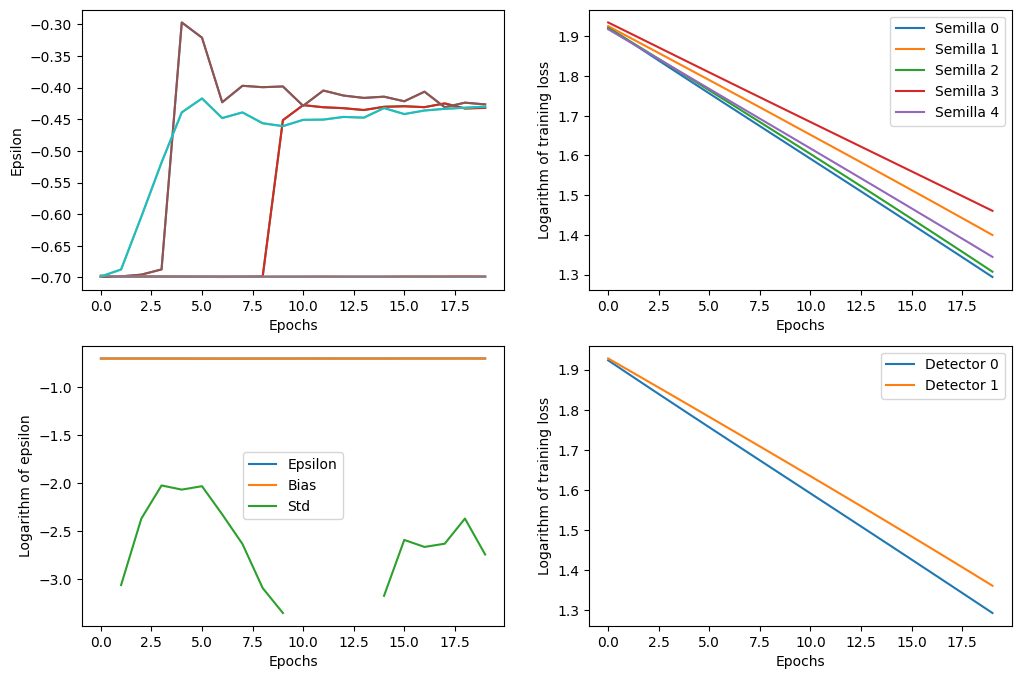

In [44]:
epsilon = np.array(epsilon, dtype='float64')
bias = np.array(bias, dtype='float64')
std = np.array(std, dtype='float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')

print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 0
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  plt.plot(np.log10(epsilon[i,:]))
  plt.plot(np.log10(epsilon[i,:]))
plt.ylabel('Epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Semilla' + ' ' + str(i)
  plt.plot(np.log10(training_loss_dec0[i,:]),label=label)
  #plt.plot(np.log10(training_loss_dec1[i,:]),label=label)
plt.legend()
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label= 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'Std')
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]),label='Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]),label='Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()


V82: CENTROID(ns) = 0.162  FWHM(ns) = 0.234  std(ns) = 0.099
V55: CENTROID(ns) = 0.001  FWHM(ns) = 0.195  std(ns) = 0.083
V28: CENTROID(ns) = -0.217  FWHM(ns) = 0.210  std(ns) = 0.089


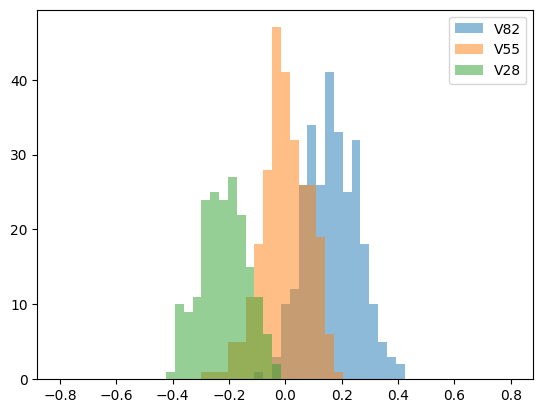

In [37]:
epoch = 5
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))